
The Project: Advanced Lane Finding
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Calibration Images

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.imshow(img)
#         plt.show()

In [4]:
test_images = glob.glob('test_images/*.jpg')

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    return hls


def color_select(img, color_lower, color_upper, bin_thresh=(0, 255)):
    color = cv2.inRange(img, color_lower, color_upper)
    binary = np.zeros_like(color)
    binary[(color > bin_thresh[0]) & (color <= bin_thresh[1])] = 1
    return binary

def merge_binary(img1, img2, img3, img4):
    merged = np.zeros_like(img1)
    merged[(img1 == 1) | (img2 == 1) | (img3 == 1) | (img4 == 1)] = 1
    return merged

def grayscale(img, thresh = (0, 255)):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

In [6]:
def thresholder(roi):
    yellow_low = np.array([200, 80, 0], dtype = "uint8")
    yellow_high = np.array([255, 255, 150], dtype = "uint8")
    white_low = np.array([210, 210, 210], dtype = "uint8")
    white_high = np.array([255, 255, 255], dtype = "uint8")
    mix_thresh1 = np.array([220, 150, 0], dtype = "uint8")
    mix_thresh2 = np.array([255, 255, 255], dtype = "uint8")
    hls_thresh1 = np.array([15, 50, 95], dtype = "uint8")
    hls_thresh2 = np.array([27, 255, 255], dtype = "uint8")
    
    hls = hls_select(roi, thresh=(0, 255))
    yellow = color_select(roi, yellow_low, yellow_high)
    white = color_select(roi, white_low, white_high)
    hls_yellow = color_select(hls, hls_thresh1, hls_thresh2)
    mix = color_select(roi, mix_thresh1, mix_thresh2)
    merged = merge_binary(yellow, white, hls_yellow, mix)
    
    return merged

def warper_unwarper(img, unwarp = False):
    img_size = (1280, 720)
    src = np.float32([[240, 680],[570, 460], [720, 460], [1140, 680]])
    offset = 200
    dst = np.float32([[offset, img_size[1]], 
                      [offset, 0], 
                      [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    if(unwarp == True):
        M = cv2.getPerspectiveTransform(dst, src) # transform matrix
    else:
        M = cv2.getPerspectiveTransform(src, dst) # transform matrix
        
    warped_unwarped = cv2.warpPerspective(img, M, img_size)
    return warped_unwarped

In [7]:
for fname in test_images:
    img = mpimg.imread(fname)
    roi_vertices = np.array([[(120, 670),(545, 450), (735, 450), (1160, 670)]], dtype=np.int32)
    undist = cal_undistort(img, objpoints, imgpoints)
    plt.imsave(fname.replace('test_images/', 'output_images/undist_'), undist)
    roi = region_of_interest(undist, roi_vertices)
    plt.imsave(fname.replace('test_images/', 'output_images/roi_'), roi)
    binary = thresholder(roi)
    plt.imsave(fname.replace('test_images/', 'output_images/binary_'), binary, cmap='gray')
    warped = warper_unwarper(binary, unwarp=False)
    plt.imsave(fname.replace('test_images/', 'output_images/warped_'), warped, cmap='gray')

In [8]:
def pipline1(img, unwarp = False):
    roi_vertices = np.array([[(120, 670),(545, 450), (735, 450), (1160, 670)]], dtype=np.int32)
    undist = cal_undistort(img, objpoints, imgpoints)
    roi = region_of_interest(undist, roi_vertices)
    binary = thresholder(roi)
    warped = warper_unwarper(binary, unwarp)
    return warped

### Sliding Window

In [9]:
def find_lane_pixels(binary_warped):
#     print('here')
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        # print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        # (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0])
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [10]:
def fit_polynomial(binary_warped, leftx = None, lefty = None, rightx = None, righty = None, visual=False):
    # Find our lane pixels first
    if(leftx == None and lefty == None and rightx == None and righty == None):
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    else:
        out_img = binary_warped
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        pass
    
    if(lf != [] and rf != []):
        for i in range(3):
            lf.remove(lf[0])
            rf.remove(rf[0])
    lf.extend(left_fit.tolist())
    rf.extend(right_fit.tolist())
    
    if(visual==True):
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

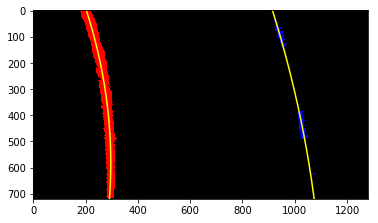

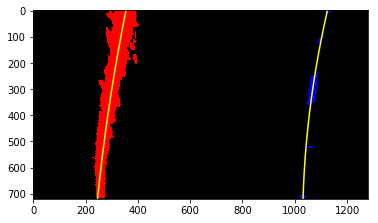

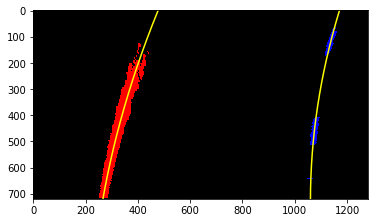

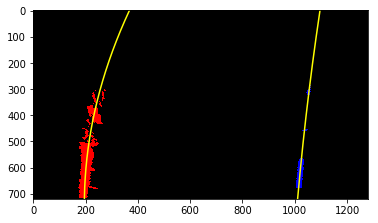

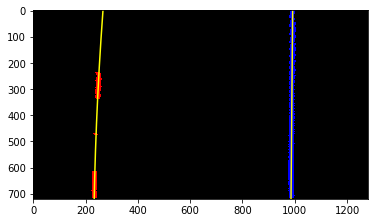

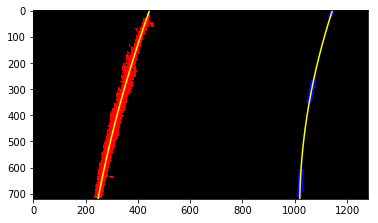

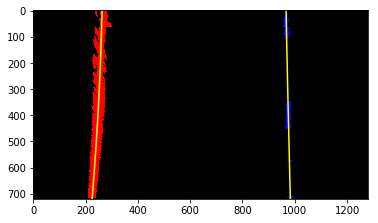

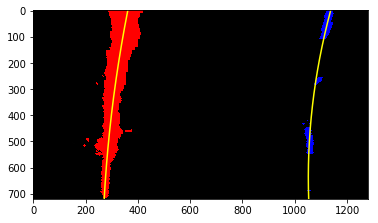

In [11]:
lf = []
rf = []
for fname in test_images:
    img = mpimg.imread(fname)
    warped = pipline1(img)
    lane_pixels, _, _, _, _, _ = fit_polynomial(warped, visual = True)
    plt.imshow(lane_pixels)
    plt.savefig(fname.replace('test_images/', 'output_images/lanepix_'))
    plt.show()

In [12]:
def search_around_poly(binary_warped):
    if (lf == [] and rf == []):
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_warped)
    else:
        left_fit = np.array(lf)
        right_fit = np.array(rf)
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy**2) +
                        left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy**2) +
                        right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    _, left_fitx, right_fitx, ploty, _, _ = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit, left_fitx, right_fitx

### Measuing Curvature

In [13]:
def curve_and_offcntr(image, ploty, left_fit, right_fit, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2 * left_fit[0])   ## the calculation of the left line here
    right_curverad = ((1 + (2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2 * right_fit[0])  ## the calculation of the right line here
    
    camera_position = image.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    offcenter_mtrs = (camera_position - lane_center) * xm_per_pix 
    if(offcenter_mtrs > 0):
        offset = 'right'
    elif(offcenter_mtrs < 0):
        offset = 'left'
    else:
        offset = 'left/right'
    
    return left_curverad, right_curverad, offcenter_mtrs, offset

In [14]:
def unwarp_and_print(unwarped, ploty, left_fit, right_fit, left_fitx, right_fitx):
    
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_pts, right_pts))
    
    warped_overlay = np.zeros_like(unwarped)
    cv2.fillPoly(warped_overlay, np.int_([lane_pts]), (0,255, 0))
    unwarped_overlay = warper_unwarper(warped_overlay, unwarp = True)
    img_with_overlay = cv2.addWeighted(unwarped, 1, unwarped_overlay, 0.3, 0)
    
    left_curverad, right_curverad, offcenter_mtrs, offset = curve_and_offcntr(unwarped, ploty, left_fit, right_fit, left_fitx, right_fitx)
    
    cv2.putText(img_with_overlay, 'Lane Curve Radius :{:.0f} m'.format(min(left_curverad, right_curverad)), (50,100), cv2.FONT_HERSHEY_COMPLEX_SMALL, 3,(255,255,255),6)
    cv2.putText(img_with_overlay, 'Vehicle is :{0:.2f} m '.format(abs(offcenter_mtrs))+ offset +' of center', (50,180), cv2.FONT_HERSHEY_COMPLEX_SMALL, 3,(255,255,255),6)
    
    return img_with_overlay
    

In [15]:
def detect_and_measure(img):
    warped = pipline1(img)
    warped_lines, ploty, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(warped)
    output_img = unwarp_and_print(img, ploty, left_fit, right_fit, left_fitx, right_fitx)
    return output_img

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


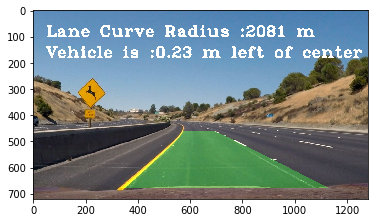

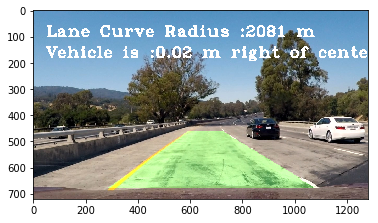

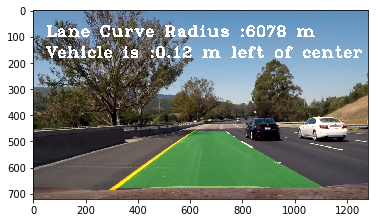

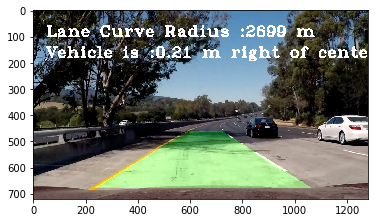

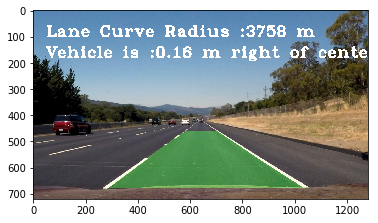

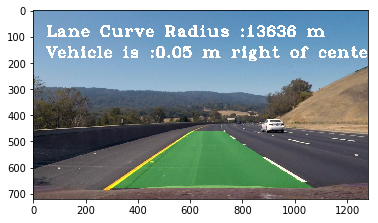

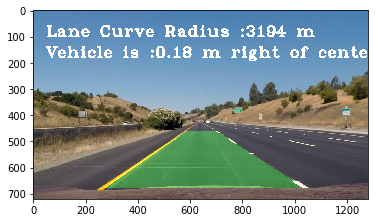

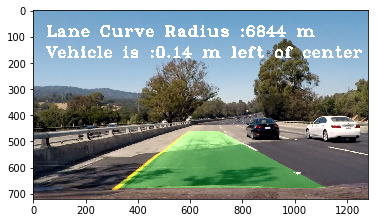

In [16]:
lf = []
rf = []
for fname in test_images:
    img = mpimg.imread(fname)
    final = detect_and_measure(img)
    plt.imsave(fname.replace('test_images/', 'output_images/final_'), final)
    plt.imshow(final)
    plt.show()
    
lf = []
rf = []

### Process pipeline on video

In [17]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_and_measure) #NOTE: this function expects color images!!
lf = []
rf = []
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [30:34<00:01,  1.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 28min 20s, sys: 2.26 s, total: 28min 23s
Wall time: 30min 37s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))